In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import sys
import sklearn
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
# import keras

In [2]:
print(tf.__version__)

2.0.0


In [3]:
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [4]:
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X,y),(X_test,y_test) = fashion_mnist.load_data()

### 切分训练集和测试集

In [6]:
# 切分训练集和验证集
X.shape
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.35)

In [7]:
X_train.shape

(39000, 28, 28)

In [8]:
y_train.shape

(39000,)

In [9]:
X_val.shape

(21000, 28, 28)

In [10]:
y_val.shape

(21000,)

In [11]:
X_train.shape

(39000, 28, 28)

In [12]:
np.random.choice(len(X_train))

28049

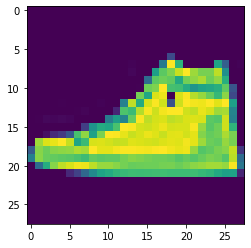

In [13]:
def show_single_image(img):
    plt.clf()
    plt.imshow(img)
    plt.show()

show_single_image(X_train[np.random.choice(len(X_train))])

In [14]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
X_train = standardScaler.fit_transform(X_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
X_val = standardScaler.fit_transform(X_val.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
X_test = standardScaler.fit_transform(X_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

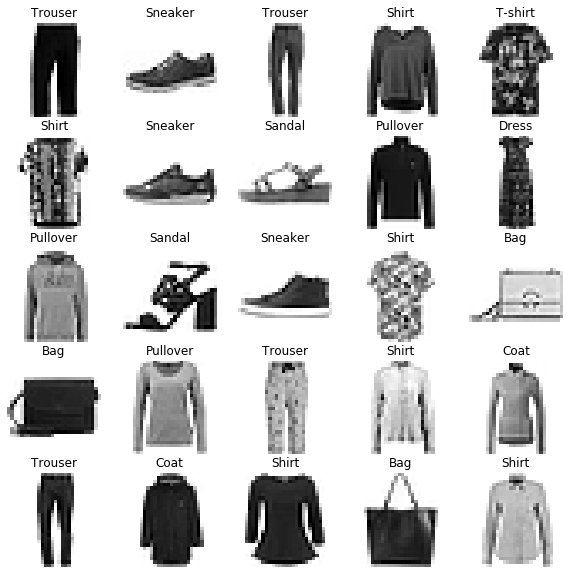

In [15]:
def show_images(r,c,X,y,class_names):
    assert len(X)==len(y)
    assert r*c != len(X)
    plt.figure(figsize=(r*2,c*2))
    for i in range(r):
        for j in range(c):
            idx = r * i + j
            plt.subplot(r,c,idx+1)
            plt.imshow(X[idx],interpolation='nearest',cmap='binary')
            plt.axis('off')
            plt.title(class_names[y[idx]])
    plt.show()
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']

show_images(5,5,X_train,y_train,class_names)

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28])) # 将28*28的矩阵展成长度为28*28的一维向量
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu'))# 自带归一化的激活函数
    #model.add(keras.layers.BatchNormalization())
    '''
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    '''
# AlphaDropout: 1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

# relu y =max(0,x)
# softmax : 将向量变成概率分布. x = [x1,x2,x3]
# y = e^x1 /sum , e^x2 / sum, e^x3 / sum 
# sum = (e^x1 + e^x2 + e^x3)

In [17]:
# why sparse y->index
# y->one_hot->[]
model.compile(
    loss="sparse_categorical_crossentropy"
    ,optimizer = keras.optimizers.SGD(0.001)
    ,metrics = ["accuracy"]
)

In [18]:
model.layers

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [20]:
# 全连接层
# 样本数 m
# [m, 784] * W + b -> [m, 300] W.shape = [784, 300], b = [300]

In [21]:
log_dir= './callbacks'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
output_model_file = os.path.join(log_dir,"fashion_mnist_model.h5")

call_backs = [
    keras.callbacks.TensorBoard(log_dir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)# 连续训练patience次差距比mindelta小时提前关闭掉
]
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val),callbacks=call_backs)
# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    批归一化缓解梯度消失

Train on 39000 samples, validate on 21000 samples
Epoch 1/10
39000/39000 [==============================] - 60s 2ms/sample - loss: 1.2820 - accuracy: 0.5561 - val_loss: 0.8754 - val_accuracy: 0.7666
Epoch 2/10
39000/39000 [==============================] - 69s 2ms/sample - loss: 0.7674 - accuracy: 0.7427 - val_loss: 0.7861 - val_accuracy: 0.8049
Epoch 3/10
39000/39000 [==============================] - 73s 2ms/sample - loss: 0.6315 - accuracy: 0.7938 - val_loss: 0.7614 - val_accuracy: 0.8263
Epoch 4/10
39000/39000 [==============================] - 55s 1ms/sample - loss: 0.5593 - accuracy: 0.8167 - val_loss: 0.7263 - val_accuracy: 0.8331
Epoch 5/10
39000/39000 [==============================] - 49s 1ms/sample - loss: 0.5203 - accuracy: 0.8292 - val_loss: 0.7008 - val_accuracy: 0.8406
Epoch 6/10
39000/39000 [==============================] - 48s 1ms/sample - loss: 0.4878 - accuracy: 0.8404 - val_loss: 0.7067 - val_accuracy: 0.8411
Epoch 7/10
39000/39000 [==============================] 

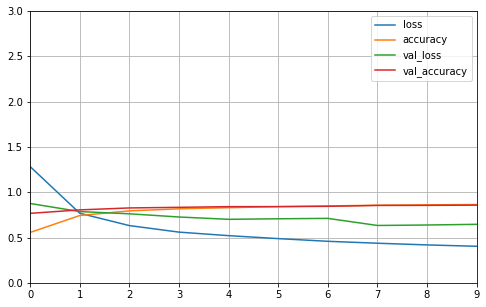

In [22]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)


In [23]:
model.evaluate(X_test, y_test, verbose=0)

[0.7127034857273101, 0.8463]